In [1]:
%matplotlib inline

import cartopy.crs as ccrs
from climada_petals.hazard.tc_rainfield import _track_to_si_with_q_and_shear
from climada.util.constants import ONE_LAT_KM
import climada.util.coordinates as u_coord
import matplotlib.pyplot as plt
import numpy as np

import tc_data.util.constants as u_const
import tc_data.util.data as u_data

In [2]:
year = 1966
max_dist_eye_km = buffer_km = u_const.MAX_STORM_SIZE_KM

In [3]:
tr = u_data.ibtracs_by_year(year, time_step_h=0.5)
tr.data = [
    t for t in tr.data
    if t.attrs["sid"] == "1966233N13340"
]
track = tr.data[0].isel(time=slice(None, None, 4))
si_track = _track_to_si_with_q_and_shear(track)
t_lat, t_lon = si_track["lat"].values, si_track["lon"].values

sha256sum: cache/tracks_hist_0.5h/1966.nc: No such file or directory
sha256sum: WARNING: 1 listed file could not be read
sha256sum: output/tracks_hist/1966.nc: No such file or directory
sha256sum: WARNING: 1 listed file could not be read


cache/tracks_hist_0.5h/1966.nc: FAILED open or read
output/tracks_hist/1966.nc: FAILED open or read
2023-07-14 09:48:25,342 - climada.hazard.tc_tracks - WARNING - 8 storm events are discarded because no valid wind/pressure values have been found: 1966001S17123, 1966065S21069, 1966254N15149, 1966254N15211, 1966265N12111, ...
2023-07-14 09:48:25,554 - climada.hazard.tc_tracks - INFO - Progress: 10%
2023-07-14 09:48:25,742 - climada.hazard.tc_tracks - INFO - Progress: 20%
2023-07-14 09:48:25,931 - climada.hazard.tc_tracks - INFO - Progress: 31%
2023-07-14 09:48:26,119 - climada.hazard.tc_tracks - INFO - Progress: 41%
2023-07-14 09:48:26,317 - climada.hazard.tc_tracks - INFO - Progress: 52%
2023-07-14 09:48:26,504 - climada.hazard.tc_tracks - INFO - Progress: 62%
2023-07-14 09:48:26,690 - climada.hazard.tc_tracks - INFO - Progress: 73%
2023-07-14 09:48:26,877 - climada.hazard.tc_tracks - INFO - Progress: 83%
2023-07-14 09:48:27,063 - climada.hazard.tc_tracks - INFO - Progress: 94%
2023-07-

In [4]:
cen = u_data.hyde_centroids()
# ignore pixels that are more than 50 km off shore
cen.dist_coast[cen.dist_coast > 50 * u_const.KM_TO_M] = 1e10
cen.dist_coast = np.abs(cen.dist_coast)
cen = cen.select(sel_cen=(cen.dist_coast < 1e9) & (cen.lat > 0))
coastal_centr = cen.coord.copy()

Load cache data from /home/tovogt/code/isimip3a_tc/cache/centroids_hyde.hdf5 ...
2023-07-14 09:48:35,435 - climada.hazard.centroids.centr - INFO - Reading /home/tovogt/code/isimip3a_tc/cache/centroids_hyde.hdf5


In [5]:
max_dist_eye_lat = max_dist_eye_km / ONE_LAT_KM
max_dist_eye_lon = max_dist_eye_km / (
    ONE_LAT_KM * np.cos(np.radians(
        np.fmin(89.999, np.abs(coastal_centr[:, 0]) + max_dist_eye_lat)
    ))
)
centr_msk_total = (
        (t_lat.min() - coastal_centr[:, 0] <= max_dist_eye_lat)
        & (coastal_centr[:, 0] - t_lat.max() <= max_dist_eye_lat)
        & (t_lon.min() - coastal_centr[:, 1] <= max_dist_eye_lon)
        & (coastal_centr[:, 1] - t_lon.max() <= max_dist_eye_lon)
)
coastal_centr = coastal_centr[centr_msk_total]
print(coastal_centr.shape[0])

1531587


In [14]:
centr_lat, centr_lon = coastal_centr[:, 0], coastal_centr[:, 1]
buffer_lat = buffer_km / ONE_LAT_KM
buffer_lon = buffer_km / (ONE_LAT_KM * np.cos(np.radians(
    np.fmin(89.999, np.abs(t_lat[:, None]) + buffer_lat)
)))
# check for each track position which centroids are within buffer, uses NumPy's broadcasting
chunk_size = 10
chunks = np.split(np.arange(t_lat.size), np.arange(chunk_size, t_lat.size, chunk_size))
centr_msk_bypos = np.array([
    (
        (t_lat[chunk, None] - buffer_lat <= centr_lat[None])
        & (t_lat[chunk, None] + buffer_lat >= centr_lat[None])
        & (t_lon[chunk, None] - buffer_lon[chunk] <= centr_lon[None])
        & (t_lon[chunk, None] + buffer_lon[chunk] >= centr_lon[None])
    ).any(axis=0)
    for chunk in chunks
]).any(axis=0)
coastal_centr = coastal_centr[centr_msk_bypos]
print(coastal_centr.shape[0])

1001220


In [ ]:
[d_centr_eq] = u_coord.dist_approx(
    t_lat[None], t_lon[None],
    coastal_centr[None, :, 0], coastal_centr[None, :, 1],
    normalize=False, method="equirect", units="km")
[d_centr_gs] = u_coord.dist_approx(
    t_lat[None], t_lon[None],
    coastal_centr[None, :, 0], coastal_centr[None, :, 1],
    normalize=False, method="geosphere", units="km")
centr_msk_disteq = d_centr_eq < max_dist_eye_km
centr_msk_distgs = d_centr_gs < max_dist_eye_km

In [11]:
print(centr_msk_distgs.any(axis=0).sum())
print(centr_msk_disteq.any(axis=0).sum())

439983
469302


In [8]:
centroids = cen.coord.copy()

centr_msk_eq = np.zeros_like(centr_msk_total, dtype=bool)
_idx = centr_msk_total.nonzero()[0]
_idx = _idx[centr_msk_bypos]
_idx = _idx[centr_msk_disteq.any(axis=0)]
centr_msk_eq[_idx] = True

centr_msk_gs = np.zeros_like(centr_msk_total, dtype=bool)
_idx = centr_msk_total.nonzero()[0]
_idx = _idx[centr_msk_bypos]
_idx = _idx[centr_msk_distgs.any(axis=0)]
centr_msk_gs[_idx] = True

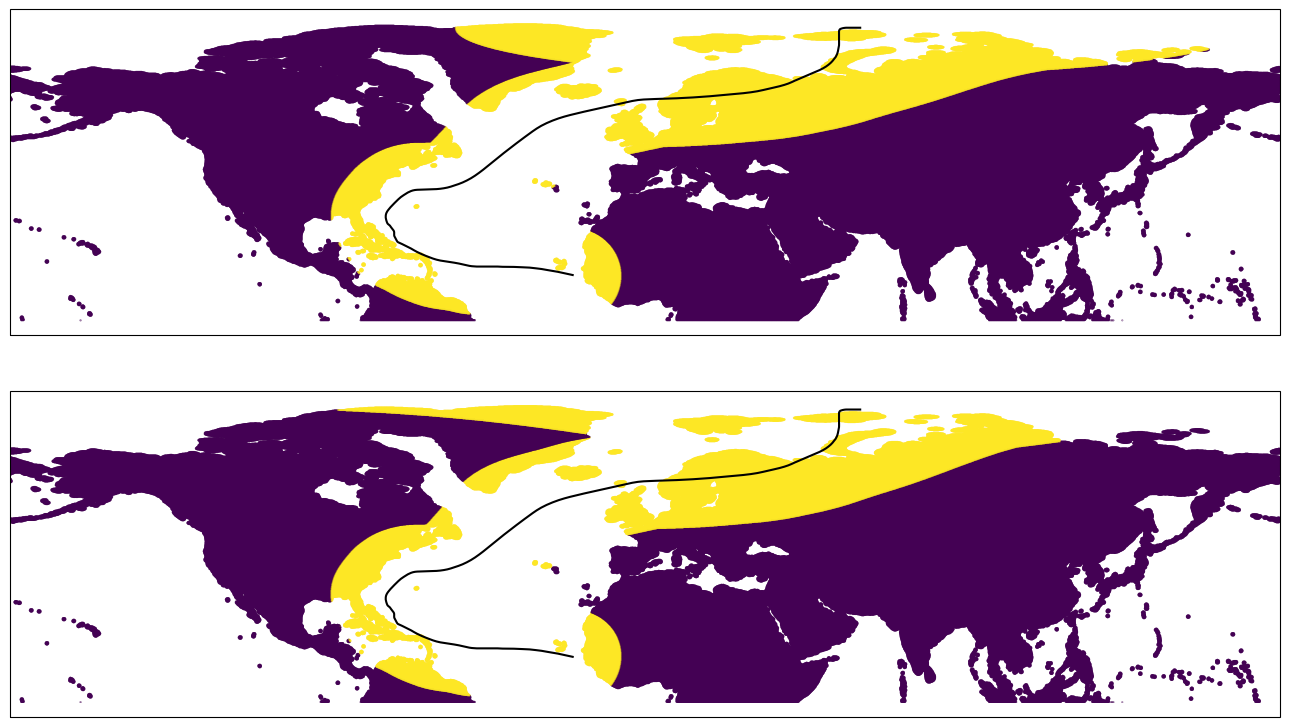

In [9]:
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax.scatter(centroids[:, 1], centroids[:, 0], s=0.01, c=centr_msk_eq)
ax.plot(t_lon, t_lat, color="black")

ax = fig.add_subplot(212, projection=ccrs.PlateCarree())
ax.scatter(centroids[:, 1], centroids[:, 0], s=0.01, c=centr_msk_gs)
ax.plot(t_lon, t_lat, color="black")

fig.tight_layout()